In [1]:
# Regex
import re
# Data Ops
import pandas as pd
import numpy as np
# Machine Learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')

### Project description and assumptions.

Beer Style Predictor

Using data available online, I will build simple supervised machine learning models (KNN, Random Forest, Adaboost Classifier) that have the obvective of classifying the general style of beer.

Features:
 1. ABV
 2. IBU
 
Target:

Style of beer.

I will assume that each sample is independant from each other, that I can drop samples with outlier or missing data accordingly, since from the previous assumption this will not affect the predictions.

For further projects I would be interested on learning how these and other features (to be included in further projects) are closest to the ones of the best rated beers by style.

### Data Sources

Included datasets:
1. From PATRICKLEDUC - "Beer Advocate Top 250 Beers", dataset for gathering beer general styles available at Kaggle: https://www.kaggle.com/datasets/bengosha/beer-advocate-top-250-beers, https://www.beeradvocate.com/beer/top-rated/ with 250 rows
2. From JAILEN BAILEY, Untappd, "Untappd Beer Data" dataset to get information for ABV, IBU and beer style available at Kaggle: https://www.kaggle.com/datasets/jailenbailey/untappd-beer-data with 251 rows
3. From Chris J Mears, Brewers Association, "Open Beer Database" to get additional rows for ABV, IBU and beer style available at: https://openbeerdb.com/ with 2754 rows

The datasets from Kaggle were downloaded directly from the site, the dataset from Open Beer DB has a csv version.

In [2]:
data_sources = {
    'beer_advocate': './data/beeradvocate_top250.csv',
    'untappd':'./data/my_beer.csv',
    'open_beer':'./data/open_beer.csv'
}

df_beer_advocate, df_untappd, df_open_beer = (pd.read_csv(data_sources[f]) for f in data_sources)
df_untappd = df_untappd.rename(columns={'beer_type':'beer_style','global_rating_score':'review_overall'})


In [3]:
print(df_beer_advocate.info())
print(df_untappd.info())
print(df_open_beer.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   rank           250 non-null    int64  
 1   beer_name      250 non-null    object 
 2   brewery        250 non-null    object 
 3   style          250 non-null    object 
 4   alcohol_pct    248 non-null    float64
 5   n_ratings      250 non-null    int64  
 6   avg_rating     250 non-null    float64
 7   general_style  250 non-null    object 
 8   substyle       230 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 17.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   beer_name                     251 non-null    object 
 1   brewery_name                  251 non-null    object 
 2 

In [4]:
df_beer_advocate.sample(5)

,rank,beer_name,brewery,style,alcohol_pct,n_ratings,avg_rating,general_style,substyle
214,215,Affogato,Trillium Brewing Company,Stout - American Imperial,13.3,424,4.50,Stout,American Imperial
181,182,Art,Hill Farmstead Brewery,Farmhouse Ale - Saison,6.5,527,4.51,Farmhouse Ale,Saison
241,242,Barrel Aged Christmas Bomb!,Prairie Artisan Ales,Stout - American Imperial,13.0,215,4.50,Stout,American Imperial
138,139,Moment Of Clarity,Tree House Brewing Company,Stout - Sweet / Milk,7.7,540,4.53,Stout,Sweet / Milk
48,49,Trappist Westvleteren 12 (XII),Brouwerij Westvleteren (Sint-Sixtusabdij van W...,Quadrupel (Quad),10.2,6794,4.61,Quadrupel (Quad),NaN


In [5]:
df_untappd.iloc[:,:5].sample(5)

,beer_name,brewery_name,beer_style,beer_abv,beer_ibu
128,Sparkly Princess,Holy City Brewing,IPA - Sour,6.6,0
185,Shroud of Mist,BattleMage Brewing,IPA - American,6.9,0
204,Sunshine & Opportunity,Almanac Beer Company,Sour - Fruited,5.6,0
42,German Coast,Rügener Insel-Brauerei,IPA - Imperial / Double,7.5,0
243,Bitch Monkey Sour w/ Cranberry,7 Locks Brewing,Sour - Fruited Gose,5.2,25


In [6]:
df_open_beer.sample(5)

,index,beer_name,beer_abv,beer_ibu,beer_style
1008,1008,Labatt Crystal,5.0,0.0,American-Style Lager
511,511,Outta Kilter Wee-Heavy Scotch Red Ale,8.2,0.0,Scotch Ale
848,848,Special Amber,5.0,0.0,American-Style Lager
2555,2555,Cafe Amsterdam's 10th Anniversary Gruit,12.0,0.0,Fruit Beer
417,417,Weizla Hell,5.0,0.0,South German-Style Hefeweizen


### Data Exploration

##### Beer Styles

As we can see from sampling the original "Beer Review" data, there are too many beer styles to work with and few samples, so with the purpose of simplyfing, I will generalize the beer styles that are known to me and are most popular in my opinion.

In [7]:
all_gen_styles = df_beer_advocate[['general_style']].groupby('general_style').nunique().index.values
gen_styles =['IPA','Lambic','Pale Ale','Porter','Sour','Stout']
all_styles_reviews = list(df_untappd[['beer_style']].groupby('beer_style').nunique().index.values)
gen_styles += ['Ale','Altbier','Pilsner','Belgian','Bock','Weissbier','Dubbel','Bitter','Lager','Weizen','Kölsch']
gen_styles = [n.lower() for n in gen_styles]
gen_styles

['ipa',
 'lambic',
 'pale ale',
 'porter',
 'sour',
 'stout',
 'ale',
 'altbier',
 'pilsner',
 'belgian',
 'bock',
 'weissbier',
 'dubbel',
 'bitter',
 'lager',
 'weizen',
 'kölsch']

### Data Cleaning

* Let's replace the "beer_styles" values with a more general style and drop any rows that are not in the general style array.
* Drop the extra features that are not usefull.
* Concatenate the datasets from untappd and open beer, since both have ABV and IBU
* Unfortunately there are too many missing values for SRM and UPC (and only available in the open beer dataset), which would give us information about the color and original gravity of the beers. And would make extremely accurate predictors for beer style.
* Remove outliers, since we will not add more detailed styles like "Strong Ale" or "Imperial IPA" we will remove from datasets.

In [8]:
class Beer_Data:
    def __init__(self, gen_styles, df_untappd, df_open_beer, clean_only=False, clean_df_target=None) -> None:
        self.styles = [s for s in gen_styles]
        if(clean_only):
            if(clean_df_target=='df_untappd'):
                df_untappd = self.clean_data_untappd(df_untappd)
                df_untappd.dropna()
                self.df = df_untappd
                return None
            if(clean_df_target=='df_open_beer'):
                df_open_beer = self.clean_data_open_beer(df_open_beer)
                df_open_beer.dropna()
                self.df = df_open_beer
                return None
        df_untappd = self.remove_outliers(df_untappd)
        df_untappd = self.clean_data_untappd(df_untappd)
        df_untappd.dropna()
        df_open_beer = self.remove_outliers(df_open_beer)
        df_open_beer = self.clean_data_open_beer(df_open_beer)
        df_open_beer.dropna()
        frames = [df_untappd,df_open_beer]
        self.df = pd.concat(frames)
        self.columns = list(self.df.columns.values)
        self.data_X = self.df[['beer_abv','beer_ibu']]
        self.data_y = self.df['beer_style']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.data_X,
            self.data_y,
            test_size=0.2
        )

    def remove_outliers(self, df: pd.DataFrame)-> pd.DataFrame:
        outlier_styles = ['imperial','strong']
        general_style_regex = [re.compile(r'(?i)[ A-z0-9 ]*.*'+s+r'[ A-z0-9 ]*.*') for s in outlier_styles]
        i = df["beer_style"].str.contains(general_style_regex[0],regex=True) == True
        s = df["beer_style"].str.contains(general_style_regex[1],regex=True) == True
        a = df['beer_abv'] > 20
        a = df['beer_abv'] == 0
        i = df['beer_ibu'] < 1
        return df[~(i + s + a + i)]

    def clean_data_untappd(self, df: pd.DataFrame)-> pd.DataFrame:
        general_style_regex = {re.compile(r'(?i)[ A-z0-9 ]*.*'+s+r'[ A-z0-9 ]*.*'): s.capitalize() for s in self.styles}
        df.beer_style = df.beer_style.replace(
            general_style_regex,
            regex=True
        )
        df = df.drop(columns=[
            'brewery_id','bid','comment','venue_name','venue_country','venue_city', 'venue_state','venue_lat',
            'venue_lng','rating_score','created_at','checkin_url','beer_url','brewery_url','brewery_country',
            'brewery_city','brewery_state','flavor_profiles','purchase_venue','serving_type','checkin_id',
            'brewery_id','photo_url','global_weighted_rating_score','tagged_friends','total_toasts','total_comments'
        ]).assign(
            review_overall = df.review_overall,
            beer_abv = df.beer_abv,
            beer_ibu = df.beer_ibu,
            brewery_name = df.brewery_name.astype('category'),
            beer_name = df.beer_name.astype('category')
        )
        df = df.loc[df['beer_style'].isin(
            [s.capitalize() for s in gen_styles]
        )].dropna()
        return df

    def clean_data_open_beer(self, df: pd.DataFrame)-> pd.DataFrame:
        general_style_regex = {re.compile(r'(?i)[ A-z0-9 ]*.*'+s+r'[ A-z0-9 ]*.*'): s.capitalize() for s in self.styles}
        df.beer_style = df.beer_style.replace(
            general_style_regex,
            regex=True
        )
        df = df.drop(columns=[
            'index',
        ]).assign(
            beer_abv = df.beer_abv,
            beer_ibu = df.beer_ibu,
            beer_name = df.beer_name.astype('category'),
            beer_style = df.beer_style.astype('category')
        )
        df = df.loc[df['beer_style'].isin(
            [s.capitalize() for s in gen_styles]
        )].dropna()
        return df


In [9]:
beer_data = Beer_Data(gen_styles, df_untappd, df_open_beer)

### Exploratory Data Analysis

Next we can see the different outliers and empty values for ABV and IBU from the boxplots.
Left: Open Beer
Center: Untappd
Right: Combined

ABV > 100?!

Beer is usually in the range of 4-6%, some notable examples of high ABV beers are the Imperial, Strong, Dubbel, Tripel, Quadrupel, Barley Wine substyles.

IBU scale ranges from 0-120, some examples of low IBU beers are belgian ales, porters, stouts, lambics. On the other side the hoppiest beers are usually IPA's.

https://beerconnoisseur.com/articles/truth-about-origins-ipa

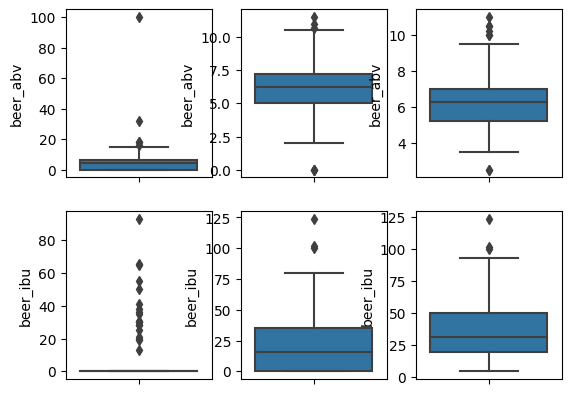

In [10]:
fig, axs = plt.subplots(nrows = 2, ncols=3)
sns.boxplot(y='beer_abv', data=df_open_beer, ax=axs[0,0])
sns.boxplot(y='beer_abv', data=df_untappd, ax=axs[0,1])
sns.boxplot(y='beer_abv', data=beer_data.df, ax=axs[0,2])
sns.boxplot(y='beer_ibu', data=df_open_beer, ax=axs[1,0])
sns.boxplot(y='beer_ibu', data=df_untappd, ax=axs[1,1])
sns.boxplot(y='beer_ibu', data=beer_data.df, ax=axs[1,2])
plt.show()

The dataset from Open Beer seems to have more outliers for both ABV and IBU. We'll remove samples with high ABV's and IBUs=0

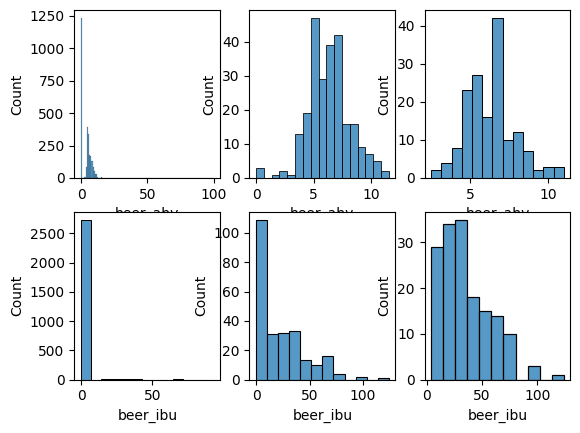

In [11]:
fig, axs = plt.subplots(nrows = 2, ncols=3)
sns.histplot(data=df_open_beer.beer_abv, ax=axs[0,0])
sns.histplot(data=df_untappd.beer_abv, ax=axs[0,1])
sns.histplot(data=beer_data.df.beer_abv, ax=axs[0,2])
sns.histplot(data=df_open_beer.beer_ibu, ax=axs[1,0])
sns.histplot(data=df_untappd.beer_ibu, ax=axs[1,1])
sns.histplot(data=beer_data.df.beer_ibu, ax=axs[1,2])
plt.show()

The distributions look very interesting, I would say that ABV's looks somewhat symmetric and IBU's a bit exponential.

My initial intention was to also include a regression model using the "Review" features present in the untappd dataset, so I will include some interesting plots with the best rated beers by ABV, IBU and style.

Here is the correlation matrix for our clean data, it doesn't look like there is much correlation between the variables.

In [12]:
beer_data.df.corr()

,beer_abv,beer_ibu,review_overall
beer_abv,1.000000,0.475609,0.404577
beer_ibu,0.475609,1.000000,0.168340
review_overall,0.404577,0.168340,1.000000


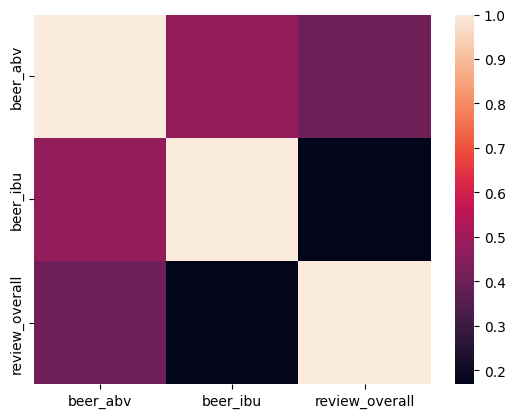

In [13]:
sns.heatmap(beer_data.df.corr())
plt.show()

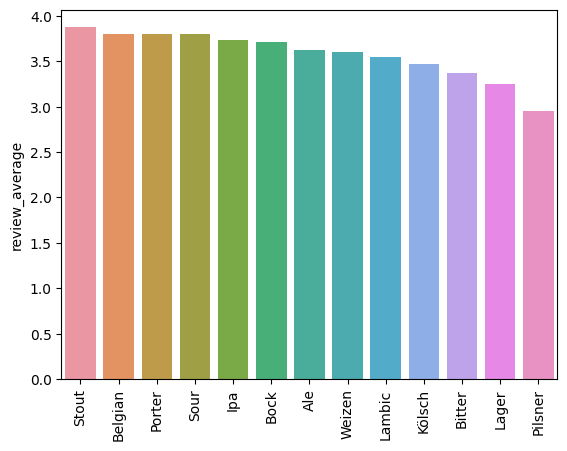

In [14]:
beer_data_untappd = Beer_Data(gen_styles, df_untappd, None, True, 'df_untappd')
review_by_style =  beer_data_untappd.df[
    ['review_overall','beer_style']
].groupby(
    'beer_style'
).aggregate(
    review_average=('review_overall','mean'),
    review_min=('review_overall','min'),
    review_max=('review_overall','max'),
    review_median=('review_overall','median')
).sort_values(
    by='review_average',ascending=False
).iloc[:15,:]
style_barplot = sns.barplot(review_by_style,x=review_by_style.index.values,y='review_average')
plt.xticks(rotation=90)
plt.show()

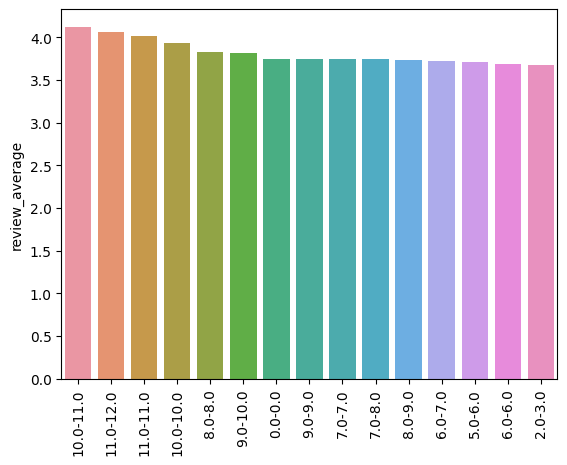

In [15]:
review_by_abv =  beer_data_untappd.df[
    ['review_overall','beer_abv']
].assign(
    abv_floor = np.floor(beer_data_untappd.df['beer_abv']),
    abv_ceil = np.ceil(beer_data_untappd.df['beer_abv'])
)
review_by_abv["abv_range"] = review_by_abv["abv_floor"].astype(str) + '-' +review_by_abv["abv_ceil"].astype(str)
review_by_abv = review_by_abv.drop(columns=['abv_floor','abv_ceil','beer_abv'])
review_by_abv = review_by_abv.groupby(
    'abv_range'
).aggregate(
    review_average=('review_overall','mean'),
).sort_values(
    by='review_average',ascending=False
).iloc[:15,:]
abv_barplot = sns.barplot(review_by_abv,x=review_by_abv.index.values,y='review_average')
plt.xticks(rotation=90)
plt.show()

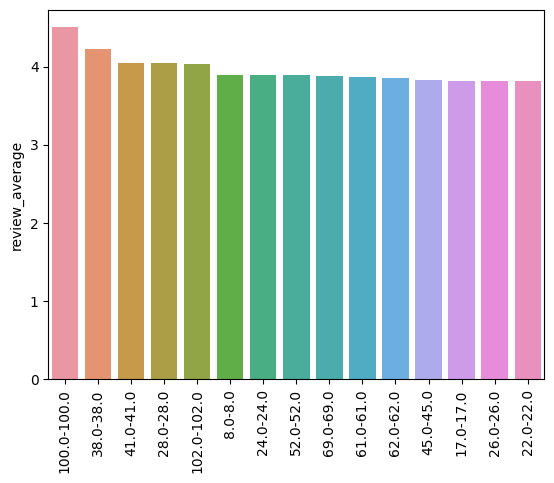

In [16]:
review_by_ibu =  beer_data_untappd.df[
    ['review_overall','beer_ibu']
].assign(
    ibu_floor = np.floor(beer_data_untappd.df['beer_ibu']),
    ibu_ceil = np.ceil(beer_data_untappd.df['beer_ibu'])
)
review_by_ibu["ibu_range"] = review_by_ibu["ibu_floor"].astype(str) + '-' +review_by_ibu["ibu_ceil"].astype(str)
review_by_ibu = review_by_ibu.drop(columns=['ibu_floor','ibu_ceil','beer_ibu'])
review_by_ibu = review_by_ibu.groupby(
    'ibu_range'
).aggregate(
    review_average=('review_overall','mean'),
).sort_values(
    by='review_average',ascending=False
).iloc[:15,:]
abv_barplot = sns.barplot(review_by_ibu,x=review_by_ibu.index.values,y='review_average')
plt.xticks(rotation=90)
plt.show()

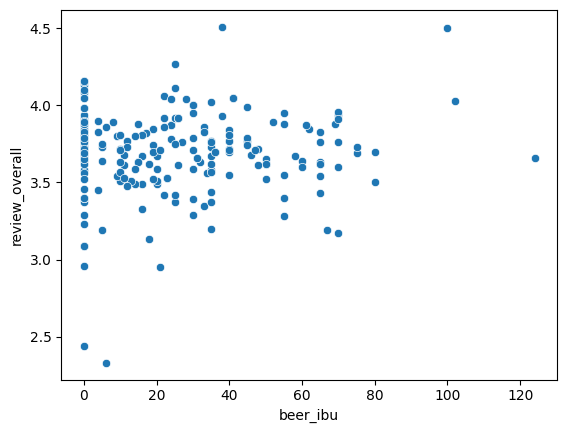

In [17]:
sns.scatterplot(beer_data_untappd.df, x='beer_ibu',y='review_overall')
plt.show()

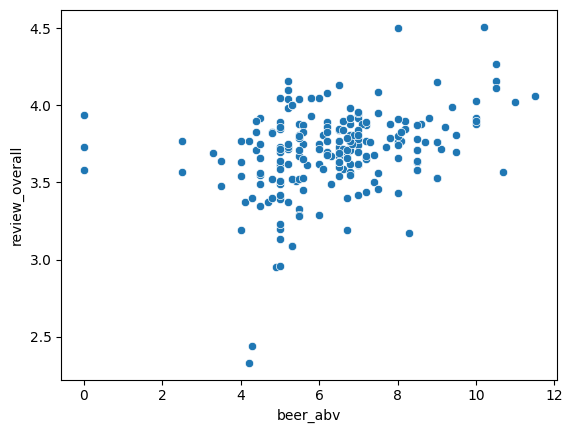

In [18]:
sns.scatterplot(beer_data_untappd.df, x='beer_abv',y='review_overall')
plt.show()

In [19]:
class Beer:
    def __init__(self, beer_data: Beer_Data, rf_md=2, ac_nestimators=200, knn_neighbors=3) -> None:
        # Random Forest
        self.random_forest = RandomForestClassifier(
            max_depth=rf_md
        ).fit(
            beer_data.X_train, 
            beer_data.y_train
        )
        self.random_forest_predictions = self.random_forest.predict(beer_data.X_test) 
        self.random_forest_score = self.random_forest.score(beer_data.X_test,beer_data.y_test)
        self.random_forest_confussion_matrix = confusion_matrix(beer_data.y_test, self.random_forest_predictions)
        # Adaboost
        self.adaboost_classifier = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=1), 
            n_estimators=ac_nestimators
        ).fit(
            beer_data.X_train, 
            beer_data.y_train
        
        )
        self.adaboost_classifier_predictions = self.adaboost_classifier.predict(beer_data.X_test)
        self.adaboost_classifier_score = self.adaboost_classifier.score(beer_data.X_test,beer_data.y_test)
        self.adaboost_classifier_confussion_matrix = confusion_matrix(beer_data.y_test, self.adaboost_classifier_predictions)
        # KNN
        self.knn = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(beer_data.X_train, beer_data.y_train)
        self.knn_predictions = self.knn.predict(beer_data.X_test) 
        self.knn_score = self.knn.score(beer_data.X_test,beer_data.y_test)
        self.knn_confussion_matrix = confusion_matrix(beer_data.y_test, self.knn_predictions)
        
        
    
    def predict_model_random_forest(self, df: pd.DataFrame)-> pd.DataFrame:
        return [str(p) for p in self.adaboost_classifier.predict(df)]

    def predict_model_adaboost(self, df: pd.DataFrame)-> pd.DataFrame:
        return [str(p) for p in self.random_forest.predict(df)]

    def predict_knn(self, df: pd.DataFrame)-> pd.DataFrame:
        return [str(p) for p in self.knn.predict(df)]

### Results and Analysis

Above you can see the beer class that predicts the beer style according to IBUs and ABVs. It fits a random forest classifier, adaboost classifier and knn neighbors. After using different parameters for each. It looks like the KNN got the best results. 

The prediction scores are not very precise, and using a larger dataset with Price, SRM, UPC would probably be very accurate. Web scraping a website like Untappd would be very interesting but is out of the scope of this project.

I believe with only two features and a small dataset, KNN is the better suited candidate model.

In [20]:
trials = [
    (2, 50, 2),
    (3, 100, 3),
    (4, 150, 4),
    (5, 200, 5),
    (6, 250, 6),
    (7, 300, 7),
    (8, 350, 8),
    (9, 400, 9),
    (10, 450, 10)
]
models = []
for d, e, n in trials:
    m = Beer(beer_data, d, e, n)
    models.append(m)
    print(m.random_forest_score, m.adaboost_classifier_score, m.knn_score)


0.53125 0.5 0.46875
0.53125 0.5 0.625
0.59375 0.5 0.59375
0.5625 0.5 0.625
0.5625 0.5 0.65625
0.53125 0.5 0.625
0.625 0.5 0.625
0.65625 0.5 0.5625
0.59375 0.5 0.5


Finally I will feed the models with a dataset with popular beers for each style and see the results.

In [21]:
my_test = pd.DataFrame(data={
    'name':['Lagunitas','Guinness','Duvel','Franziskaner', 'Corona', 'Sierra Nevada Torpedo', 'Orval', 'Fullers London Pride', 'Heineken', 'Meantime London Porter'],
    'beer_abv':[6.2, 4.2, 8.5, 5, 4.5, 7.2, 6.2, 4.7, 5, 6.5],
    'beer_ibu':[51, 45, 33, 10, 18, 65, 36, 22, 19, 35]
})
my_test

,name,beer_abv,beer_ibu
0,Lagunitas,6.2,51
1,Guinness,4.2,45
2,Duvel,8.5,33
3,Franziskaner,5.0,10
4,Corona,4.5,18
5,Sierra Nevada Torpedo,7.2,65
6,Orval,6.2,36
7,Fullers London Pride,4.7,22
8,Heineken,5.0,19
9,Meantime London Porter,6.5,35


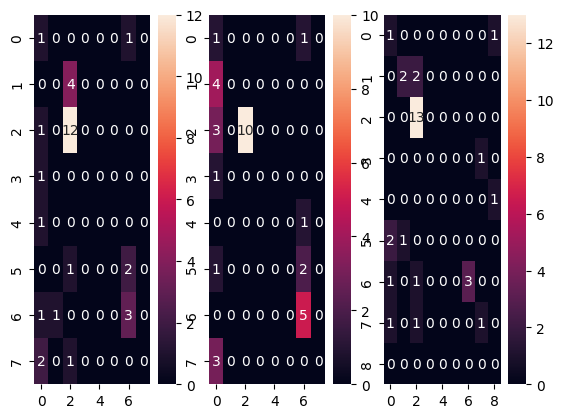

Name: Lagunitas, Random Forest: Ipa, AdaBoost: Ipa, KNN: Ipa
Name: Guinness, Random Forest: Ipa, AdaBoost: Ale, KNN: Ipa
Name: Duvel, Random Forest: Ale, AdaBoost: Ipa, KNN: Stout
Name: Franziskaner, Random Forest: Sour, AdaBoost: Sour, KNN: Sour
Name: Corona, Random Forest: Ale, AdaBoost: Ale, KNN: Lager
Name: Sierra Nevada Torpedo, Random Forest: Ipa, AdaBoost: Ipa, KNN: Ipa
Name: Orval, Random Forest: Ale, AdaBoost: Ale, KNN: Ale
Name: Fullers London Pride, Random Forest: Ale, AdaBoost: Ale, KNN: Ale
Name: Heineken, Random Forest: Ale, AdaBoost: Ale, KNN: Lager
Name: Meantime London Porter, Random Forest: Ale, AdaBoost: Ipa, KNN: Ipa


In [23]:
beer = Beer(beer_data, 2, 50, 3)
fig, axs = plt.subplots(nrows = 1, ncols=3)
sns.heatmap(beer.random_forest_confussion_matrix, annot=True, ax=axs[0])
sns.heatmap(beer.adaboost_classifier_confussion_matrix, annot=True, ax=axs[1])
sns.heatmap(beer.knn_confussion_matrix, annot=True, ax=axs[2])
plt.show()
rf_pred = beer.predict_model_random_forest(my_test.iloc[:,1:])
ab_pred = beer.predict_model_adaboost(my_test.iloc[:,1:])
knn_pred = beer.predict_knn(my_test.iloc[:,1:])
names = [v[0] for v in my_test.iloc[:,:1].values]
for t, rf, ab, knn in zip(names,rf_pred, ab_pred, knn_pred):
    print(f'Name: {t}, Random Forest: {rf}, AdaBoost: {ab}, KNN: {knn}')

### Conclusion
This are promising results, nevertheless, for next iteration of this project extra features are really necessary. For the time contraints of this first version, I was not able to gather data with features like SRM, UPC and price. I am interested in constructing a similar model that based on the highest rated reviews of beers on sites like Untappd and Beer Advocate I could get the ideal parameters (other than the existing ones: https://www.brewersassociation.org/edu/brewers-association-beer-style-guidelines/) for IBU, ABV, SRM, UPC and Price.
